In [1]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import quandl
import scipy.optimize as sco

plt.style.use('fivethirtyeight')
np.random.seed(777)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
quandl.ApiConfig.api_key = '8Nc17RkZY1ybu9DXpjWx'
stocks = ['AAPL','AMZN','GOOGL','FB']
data = quandl.get_table('WIKI/PRICES', ticker = stocks,
                        qopts = { 'columns': ['date', 'ticker', 'adj_close'] },
                        date = { 'gte': '2016-1-1', 'lte': '2017-12-31' }, paginate=True)
data.head()

# adj closing price is a closing price adjusted for corporate actions
# such as stock dividends, cash dividends, stock splits, etc.

# paginate = True allows for downloading limit of 1M rows per call
# for free users of quandl, 2000 calls/10 minutes (speed limit) and 50K calls per day(volume limit)

,date,ticker,adj_close
None,,,
0,2017-12-29,GOOGL,1053.40
1,2017-12-28,GOOGL,1055.95
2,2017-12-27,GOOGL,1060.20
3,2017-12-26,GOOGL,1065.85
4,2017-12-22,GOOGL,1068.86


In [3]:
data.info()
# date is already in datetime format

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2006 entries, 0 to 2005
Data columns (total 3 columns):
date         2006 non-null datetime64[ns]
ticker       2006 non-null object
adj_close    2006 non-null float64
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 47.1+ KB


In [4]:
df = data.set_index('date')
# set the index labels(rows' labels) to some column

In [5]:
df.head(5)

,ticker,adj_close
date,,
2017-12-29,GOOGL,1053.40
2017-12-28,GOOGL,1055.95
2017-12-27,GOOGL,1060.20
2017-12-26,GOOGL,1065.85
2017-12-22,GOOGL,1068.86


In [6]:
table = df.pivot(columns='ticker')
# column used to make new frame's columns

In [7]:
table.head(10)

adj_close                        
ticker            AAPL    AMZN      FB   GOOGL
date                                          
2016-01-04  101.783763  636.99  102.22  759.44
2016-01-05   99.233131  633.79  102.73  761.53
2016-01-06   97.291172  632.65  102.97  759.33
2016-01-07   93.185040  607.94   97.92  741.00
2016-01-08   93.677776  607.05   97.33  730.91
2016-01-11   95.194629  617.74   97.51  733.07
2016-01-12   96.576222  617.89   99.37  745.34
2016-01-13   94.093220  581.81   95.44  719.57
2016-01-14   96.151117  593.00   98.37  731.39
2016-01-15   93.842021  570.18   94.97  710.49

In [13]:
table.columns

MultiIndex(levels=[['adj_close'], ['AAPL', 'AMZN', 'FB', 'GOOGL']],
           labels=[[0, 0, 0, 0], [0, 1, 2, 3]],
           names=[None, 'ticker'])

In [15]:
 for x in table.columns:
        print(x[1])

AAPL
AMZN
FB
GOOGL


In [16]:
# By specifying col[1] in below list comprehension
# You can select the stock names under multi-level column
table.columns = [col[1] for col in table.columns]
table.head()

,AAPL,AMZN,FB,GOOGL
date,,,,
2016-01-04,101.783763,636.99,102.22,759.44
2016-01-05,99.233131,633.79,102.73,761.53
2016-01-06,97.291172,632.65,102.97,759.33
2016-01-07,93.185040,607.94,97.92,741.00
2016-01-08,93.677776,607.05,97.33,730.91


In [17]:
table.columns.values

array(['AAPL', 'AMZN', 'FB', 'GOOGL'], dtype=object)

Text(0,0.5,'price in $')

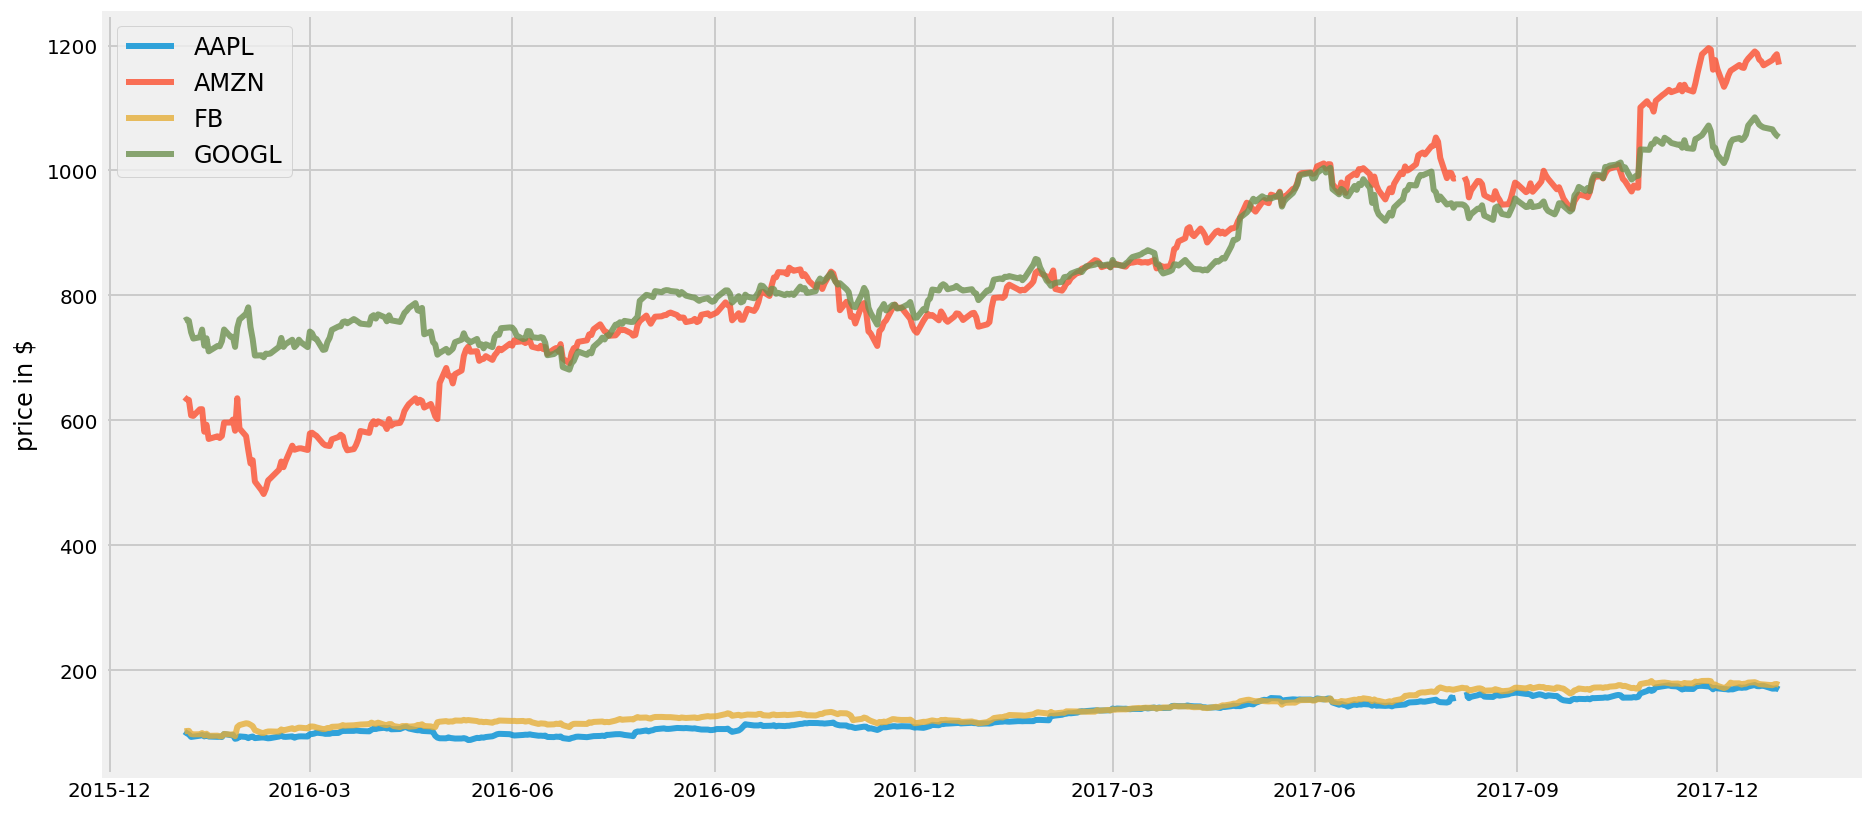

In [20]:
plt.figure(figsize=(14, 7))
for c in table.columns.values:
    plt.plot(table.index, table[c], lw=3, alpha=0.8,label=c)
# lw is linewidth 
# alpha is transparancy    

plt.legend(loc='upper left', fontsize=12)
plt.ylabel('price in $')

Text(0,0.5,'daily returns')

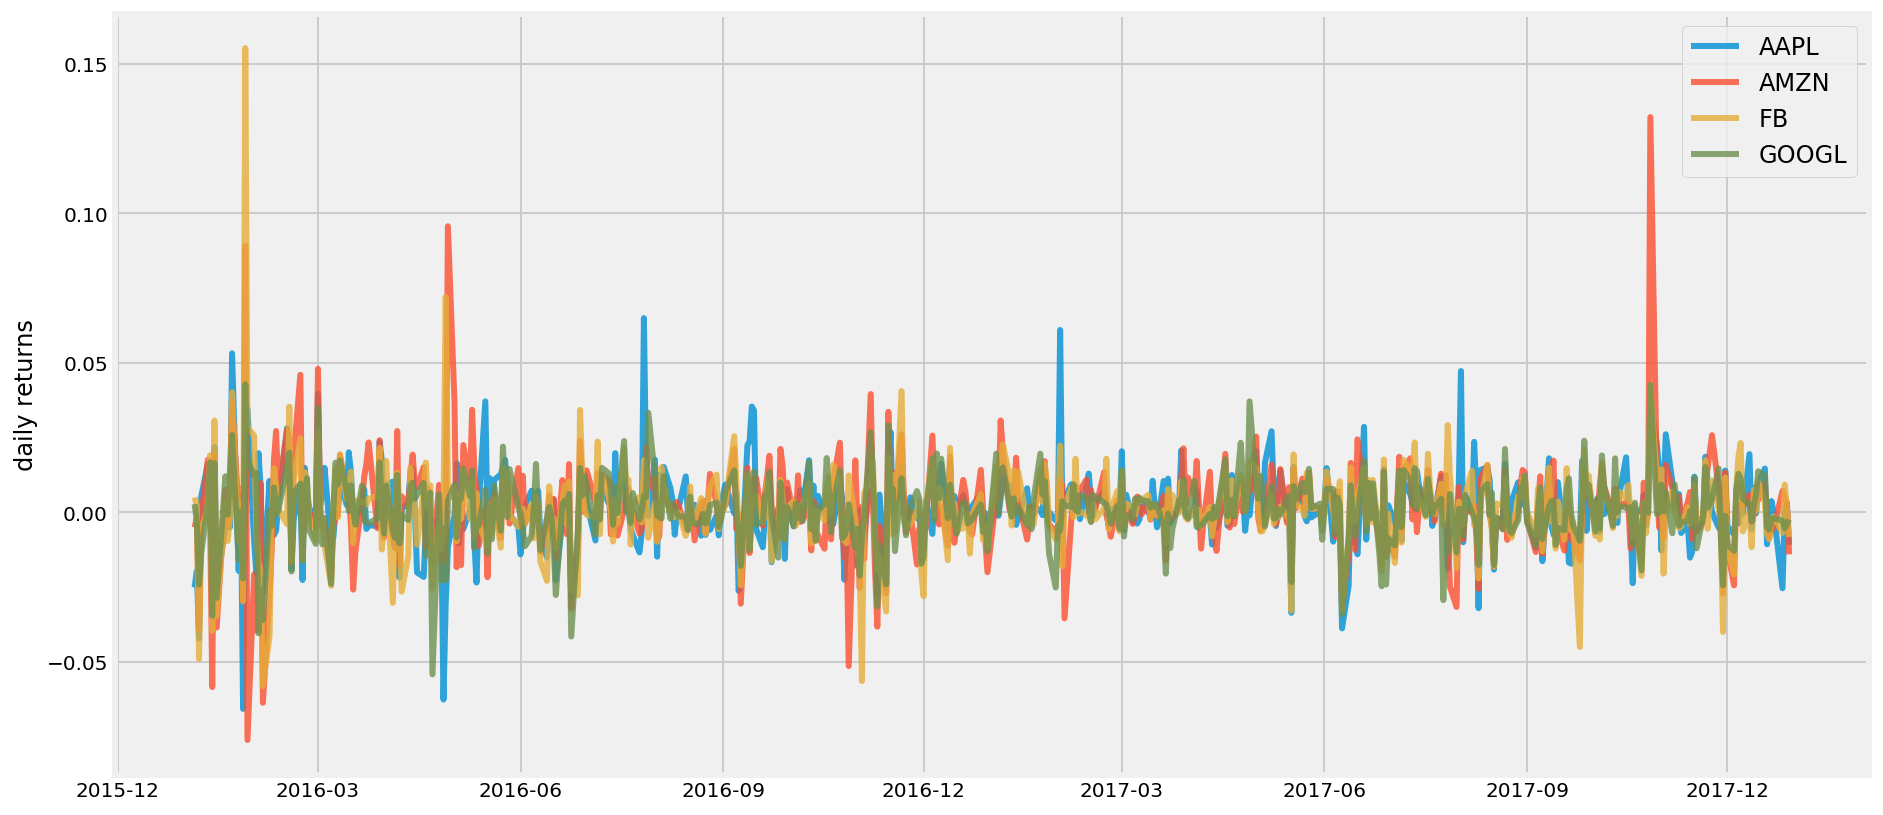

In [22]:
returns = table.pct_change()
# (P2-P1)/P1

plt.figure(figsize=(14, 7))
for c in returns.columns.values:
    plt.plot(returns.index, returns[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper right', fontsize=12)
plt.ylabel('daily returns')

In [27]:
def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns*weights ) *252
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return std, returns
  
    
# Like Monte-Carlo, weights are random variables
# Portfolio returns, std and Sharpe are then calculated
# constraints are set implicitly np.random.random will give
# weights>0 and when they're normalized the sum is 1
def random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    results = np.zeros((3,num_portfolios))
    #portfolio std, return and Sharpe
    
    weights_record = []
    
    for i in range(num_portfolios):
        weights = np.random.random(4)
        # since we got 4 assets
        
        weights /= np.sum(weights)
        # normalize weights
        
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return results, weights_record

In [28]:
returns = table.pct_change()
mean_returns = returns.mean()
cov_matrix = returns.cov()
num_portfolios = 25000
risk_free_rate = 0.0178
# 52 week US treasury rate at 1.78% or 178 bp

In [29]:
def display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    # first, random portfolios are generated
    results, weights = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
    
    max_sharpe_idx = np.argmax(results[2])
    sdp, rp = results[0,max_sharpe_idx], results[1,max_sharpe_idx]
    # np.argmax(results[2]) gives index of highets Sharpe
    # finds such sdp and rp that their Sharpes are max
    
    max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_idx],index=table.columns,columns=['allocation'])
    # creates dataframe with weights of max sharpe as data 
    # Asset names as indices; 'Allocation' as column name
    
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    
    
    # minimum volatility is taken as optimization goal
    min_vol_idx = np.argmin(results[0])
    sdp_min, rp_min = results[0,min_vol_idx], results[1,min_vol_idx]
    min_vol_allocation = pd.DataFrame(weights[min_vol_idx],index=table.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    print ("-"*80)
    print ("Maximum Sharpe Ratio Portfolio Allocation\n")
    print ("Annualised Return:", round(rp,2))
    print ("Annualised Volatility:", round(sdp,2))
    print ("\n")
    print (max_sharpe_allocation)
    print ("-"*80)
    print ("Minimum Volatility Portfolio Allocation\n")
    print ("Annualised Return:", round(rp_min,2))
    print ("Annualised Volatility:", round(sdp_min,2))
    print ("\n")
    print (min_vol_allocation)
    
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    # red asterisk is max Sharpe
    
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')
    # green asterisk is min volatility
    
    plt.title('Simulated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('annualised volatility')
    plt.ylabel('annualised returns')
    plt.legend(labelspacing=0.8)

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.3
Annualised Volatility: 0.18


             AAPL   AMZN     FB  GOOGL
allocation  43.93  29.49  26.51   0.07
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.22
Annualised Volatility: 0.16


             AAPL  AMZN    FB  GOOGL
allocation  34.12  0.04  8.25  57.59


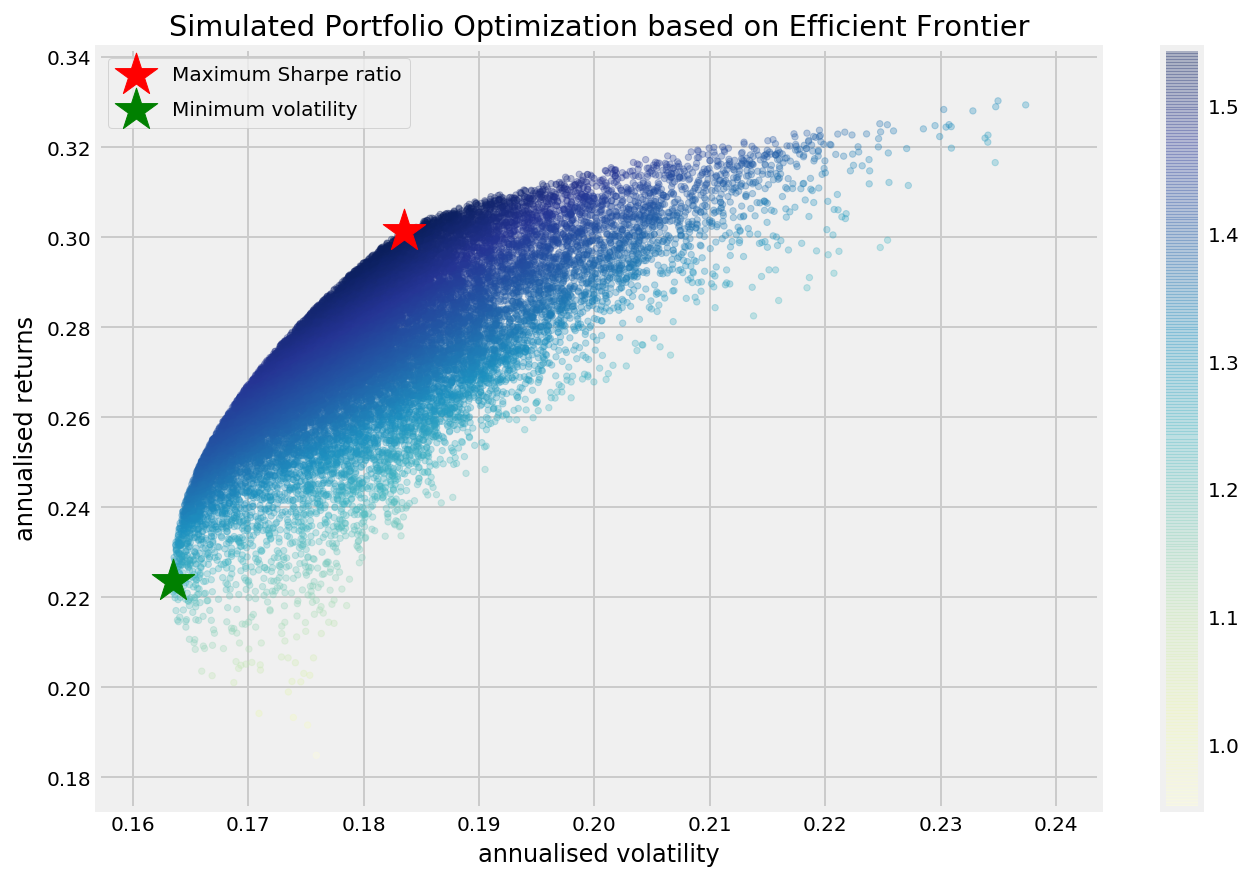

In [32]:
display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate)

In [ ]:
# highest sharpe portfolio allocates to Google < 1%
# min risk portfolio mostly allocates to Google, which has lowest std

In [48]:
4*[1./4]

[0.25, 0.25, 0.25, 0.25]

In [50]:
# Let's try optimizing Sharpe first

def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    p_var, p_ret = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
    return -(p_ret - risk_free_rate) / p_var
# first parameter, i.e. weights will be optimized; others are extra args
# which will be required to spec the function

def max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(neg_sharpe_ratio, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    
    # [0.25,0.25,0.25,0.25] are initial guesses
    
    # args are extra arguments needed to completely specify the function
    # the parameter should be (n,) dimension
    
    # constraint is that sum of weights have to equal 1
    
    # bounds for L-BFGS-B, TNC, SLSQP and trust-constr methods. If none, there's no 
    # constraints on bounds. We have bounds of (0,1)
    
    # type: eq means equality
    # fun: function defining constraints 
    return result

In [51]:
# Now minimise volatility 

def portfolio_volatility(weights, mean_returns, cov_matrix):
    return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[0]

def min_variance(mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))

    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)

    return result

In [52]:
# Let's build efficient frontier 
def efficient_return(mean_returns, cov_matrix, target):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)

    def portfolio_return(weights):
        return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[1]

    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_return(x) - target},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0,1) for asset in range(num_assets))
    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args, method='SLSQP',
                          bounds=bounds, constraints=constraints)
    return result


def efficient_frontier(mean_returns, cov_matrix, returns_range):
    efficients = []
    for ret in returns_range:
        efficients.append(efficient_return(mean_returns, cov_matrix, ret))
    return efficients

In [53]:
def display_calculated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, _ = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
    
    max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
    sdp, rp = portfolio_annualised_performance(max_sharpe['x'], mean_returns, cov_matrix)
    max_sharpe_allocation = pd.DataFrame(max_sharpe.x,index=table.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T

    min_vol = min_variance(mean_returns, cov_matrix)
    sdp_min, rp_min = portfolio_annualised_performance(min_vol['x'], mean_returns, cov_matrix)
    min_vol_allocation = pd.DataFrame(min_vol.x,index=table.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    print ("-"*80)
    print ("Maximum Sharpe Ratio Portfolio Allocation\n")
    print ("Annualised Return:", round(rp,2))
    print ("Annualised Volatility:", round(sdp,2))
    print ("\n")
    print (max_sharpe_allocation)
    print ("-"*80)
    print ("Minimum Volatility Portfolio Allocation\n")
    print ("Annualised Return:", round(rp_min,2))
    print ("Annualised Volatility:", round(sdp_min,2))
    print ("\n")
    print (min_vol_allocation)
    
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')

    target = np.linspace(rp_min, 0.32, 50)
    efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)
    plt.plot([p['fun'] for p in efficient_portfolios], target, linestyle='-.', color='black', label='efficient frontier')
    plt.title('Calculated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('annualised volatility')
    plt.ylabel('annualised returns')
    plt.legend(labelspacing=0.8)

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.3
Annualised Volatility: 0.18


             AAPL   AMZN     FB  GOOGL
allocation  44.67  29.05  26.28    0.0
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.22
Annualised Volatility: 0.16


             AAPL  AMZN    FB  GOOGL
allocation  34.02  0.73  6.98  58.26


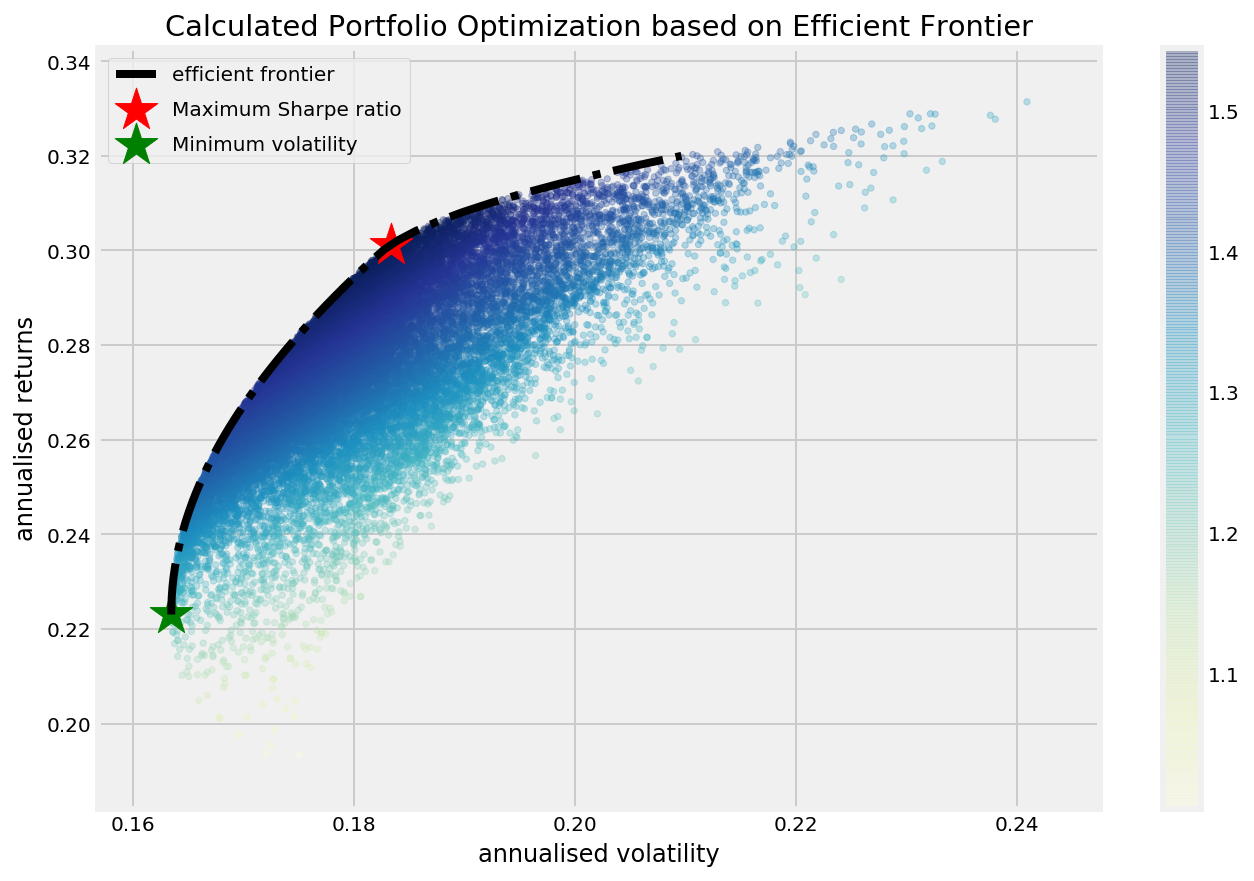

In [54]:
display_calculated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate)

In [55]:
# almost same results as when randomization was used

In [56]:
def display_ef_with_selected(mean_returns, cov_matrix, risk_free_rate):
    max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
    sdp, rp = portfolio_annualised_performance(max_sharpe['x'], mean_returns, cov_matrix)
    max_sharpe_allocation = pd.DataFrame(max_sharpe.x,index=table.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T

    min_vol = min_variance(mean_returns, cov_matrix)
    sdp_min, rp_min = portfolio_annualised_performance(min_vol['x'], mean_returns, cov_matrix)
    min_vol_allocation = pd.DataFrame(min_vol.x,index=table.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    an_vol = np.std(returns) * np.sqrt(252)
    an_rt = mean_returns * 252
 

    print ("-"*80)
    print ("Maximum Sharpe Ratio Portfolio Allocation\n")
    print ("Annualised Return:", round(rp,2))
    print ("Annualised Volatility:", round(sdp,2))
    print ("\n")
    print (max_sharpe_allocation)
    print ("-"*80)
    print ("Minimum Volatility Portfolio Allocation\n")
    print ("Annualised Return:", round(rp_min,2))
    print ("Annualised Volatility:", round(sdp_min,2))
    print ("\n")
    print (min_vol_allocation)
    print ("-"*80)
    print ("Individual Stock Returns and Volatility\n")
    for i, txt in enumerate(table.columns):
        print (txt,":","annuaised return",round(an_rt[i],2),", annualised volatility:",round(an_vol[i],2))
    print ("-"*80)
    
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.scatter(an_vol,an_rt,marker='o',s=200)

    for i, txt in enumerate(table.columns):
        ax.annotate(txt, (an_vol[i],an_rt[i]), xytext=(10,0), textcoords='offset points')
    ax.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    ax.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')

    target = np.linspace(rp_min, 0.34, 50)
    efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)
    ax.plot([p['fun'] for p in efficient_portfolios], target, linestyle='-.', color='black', label='efficient frontier')
    ax.set_title('Portfolio Optimization with Individual Stocks')
    ax.set_xlabel('annualised volatility')
    ax.set_ylabel('annualised returns')
    ax.legend(labelspacing=0.8)

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.3
Annualised Volatility: 0.18


             AAPL   AMZN     FB  GOOGL
allocation  44.67  29.05  26.28    0.0
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.22
Annualised Volatility: 0.16


             AAPL  AMZN    FB  GOOGL
allocation  34.02  0.73  6.98  58.26
--------------------------------------------------------------------------------
Individual Stock Returns and Volatility

AAPL : annuaised return 0.28 , annualised volatility: 0.21
AMZN : annuaised return 0.34 , annualised volatility: 0.25
FB : annuaised return 0.3 , annualised volatility: 0.23
GOOGL : annuaised return 0.18 , annualised volatility: 0.18
--------------------------------------------------------------------------------


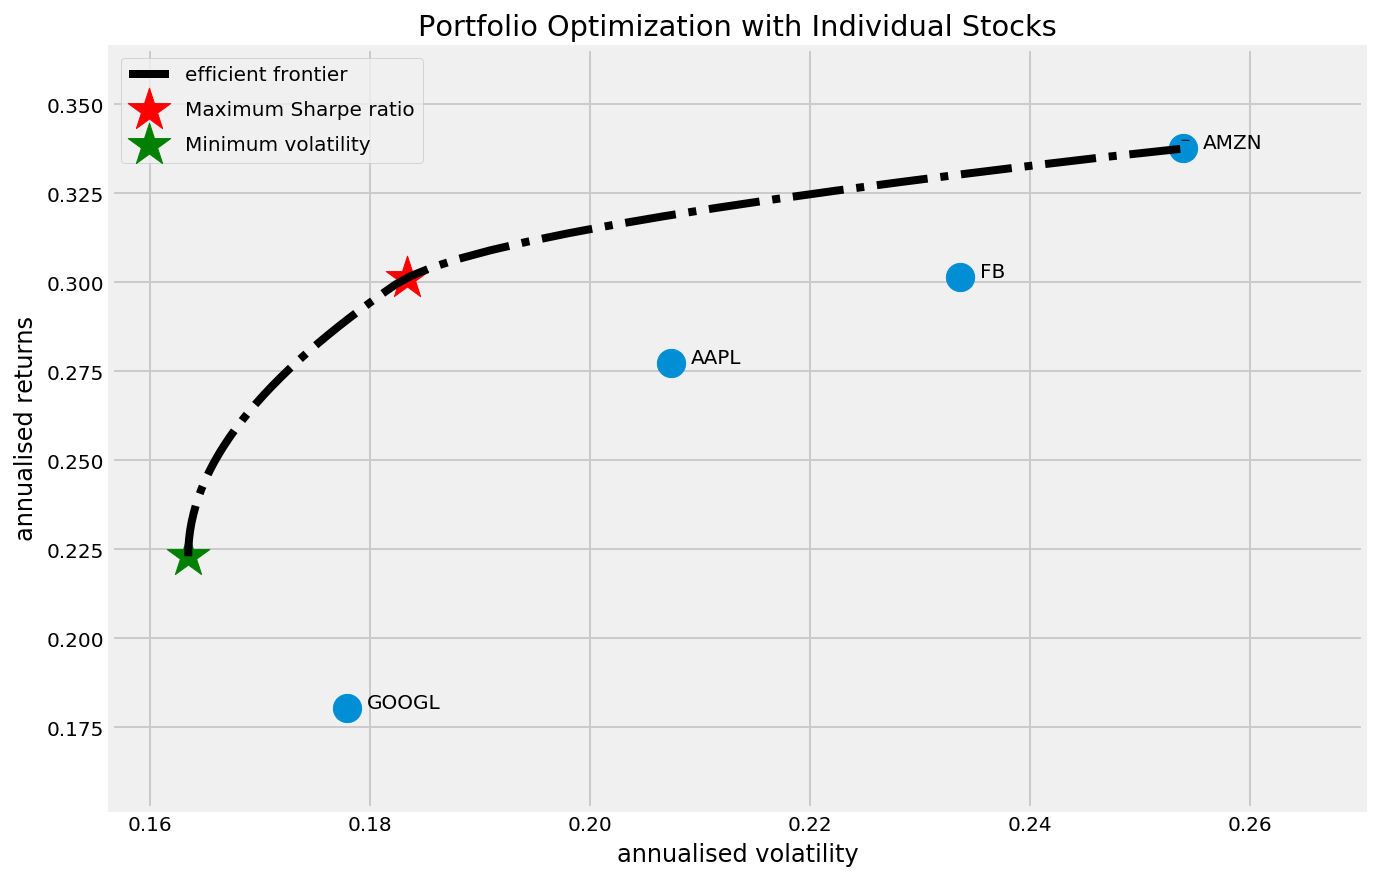

In [57]:
display_ef_with_selected(mean_returns, cov_matrix, risk_free_rate)

As you can see from the above plot, the stock with the least risk is Google at around 0.18. But with portfolio optimisation, we can achieve even lower risk at 0.16, and still with a higher return than Google. And if we are willing to take slightly more risk at around the similar level of risk of Google, we can achieve a much higher return of 0.30 with portfolio optimisation.